# Using EcoFOCIpy to apply Data Filters to 1D data

- filter examples:
    - 35hr Lanzcos Filter **good for data with tides like ADCP**
    - IQR (inter-quartile range) filter
    - STD (standard deviation) filter
    - 7pt rolling mean-value exceeds 5std of timeseries demeaned data **good for spiky data like chlor, sal in interface** and should be applied when there is a seasonal baseline shift (duration of rolling mean?) *TODO: make subroutine and output flag to variables*
    
    
- input:
    - timeseries data
- output:
    - timeseries data, flags
    
TODO:
- linearly fill (foward or back?) no more than x number of points (likely 1) -> interp_na(limit=1)
- output to xarray modified netcdf file

In [1]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
import datetime

import EcoFOCIpy.math.cleaning as cleaning #<- instrument specific
import EcoFOCIpy.math.lanzcos as lanzcos #<- instrument specific

In [2]:
# testfile = '../staticdata/example_data/nc_data/16bsm2a_eco_0000m.nc'
testfile = '/Users/bell/ecoraid/2019/Moorings/19bsm2a/working/19bsm2a_s37_0027m.unqcd.trimmed_missing.cf.nc'

So lets load a timeseries and apply filters to the entire period

In [3]:
xdf = xa.load_dataset(testfile)
xdf

<xarray.Dataset>
Dimensions:  (depth: 1, lat: 1, lon: 1, time: 3547)
Coordinates:
  * time     (time) datetime64[ns] 2019-04-25T05:00:56.999999488 ... 2019-09-...
  * depth    (depth) float32 27.0
  * lat      (lat) float32 56.87
  * lon      (lon) float32 164.1
Data variables:
    T_20     (time, depth, lat, lon) float32 3.682 3.684 3.7 ... 11.61 11.53
    P_1      (time, depth, lat, lon) float32 -9.999e+03 ... -9.999e+03
    C_50     (time, depth, lat, lon) float32 29.73 29.73 29.74 ... 36.18 36.14
    S_41     (time, depth, lat, lon) float32 31.95 31.95 31.95 ... 31.62 31.65
Attributes: (12/14)
    CREATION_DATE:        July 30, 2021 20:37 UTC
    COMPOSITE:            1
    INST_TYPE:            s37
    DATA_CMNT:            19bsm2a_s37_1852_0027m.asc
    EPIC_FILE_GENERATOR:  nc_epic2udunits_time.py V0.4.0
    PROG_CMNT01:          
    ...                   ...
    MOORING:              19bsm2a
    WATER_MASS:           
    EXPERIMENT:           
    PROJECT:              
    History:              \nSeptember 28, 2019 02:02 UTC Data Trimmed\n\nJuly...
    featureType:

In [4]:
var_choice = 'S_41'

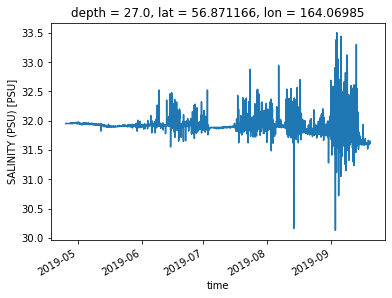

In [5]:
xdf[var_choice].plot()

In [6]:
df = xdf[var_choice][:,0,0,0].to_dataframe().drop(labels=['depth','lat','lon'],axis=1)
dft = df.dropna()
#
## missing data fill limited by number of hours to linearly interpolate
temp = dft[var_choice].interpolate(method='time',limit=6)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index = np.isnan(temp)
temp = dft[var_choice].interpolate(method='time')

#address gaps at beginning and end... back fill... and forward fill at end... 
# the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
temp.bfill(inplace=True)
temp.ffill(inplace=True)

#filter data with lanzcos filter
lanzcosfiltered = lanzcos.lanzcos(temp.values,1,35) + dft[var_choice].mean()

In [7]:
IQRcleaned = cleaning.outlier_bounds_iqr(xdf[var_choice])
STDcleaned = cleaning.outlier_bounds_std(xdf[var_choice])

(18140.0, 18154.0)

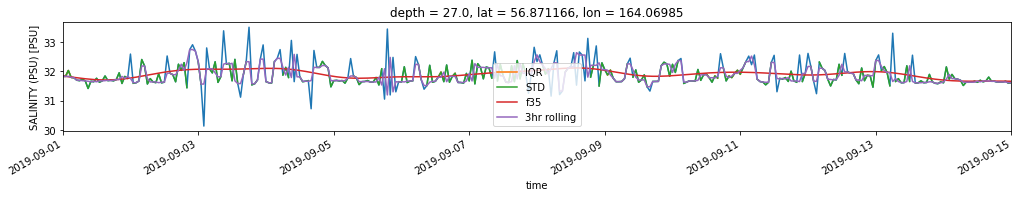

In [8]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)

ax.legend()
ax.set_xlim([datetime.date(2019,9,1),datetime.date(2019,9,15)])

But perhaps a form of rolling std/iqr filter is more appropriate as it wont tend to mask relevant peaks by being a median filter

In [9]:
xdf

<xarray.Dataset>
Dimensions:  (depth: 1, lat: 1, lon: 1, time: 3547)
Coordinates:
  * time     (time) datetime64[ns] 2019-04-25T05:00:56.999999488 ... 2019-09-...
  * depth    (depth) float32 27.0
  * lat      (lat) float32 56.87
  * lon      (lon) float32 164.1
Data variables:
    T_20     (time, depth, lat, lon) float32 3.682 3.684 3.7 ... 11.61 11.53
    P_1      (time, depth, lat, lon) float32 -9.999e+03 ... -9.999e+03
    C_50     (time, depth, lat, lon) float32 29.73 29.73 29.74 ... 36.18 36.14
    S_41     (time, depth, lat, lon) float32 31.95 31.95 31.95 ... 31.62 31.65
Attributes: (12/14)
    CREATION_DATE:        July 30, 2021 20:37 UTC
    COMPOSITE:            1
    INST_TYPE:            s37
    DATA_CMNT:            19bsm2a_s37_1852_0027m.asc
    EPIC_FILE_GENERATOR:  nc_epic2udunits_time.py V0.4.0
    PROG_CMNT01:          
    ...                   ...
    MOORING:              19bsm2a
    WATER_MASS:           
    EXPERIMENT:           
    PROJECT:              
    History:              \nSeptember 28, 2019 02:02 UTC Data Trimmed\n\nJuly...
    featureType:

(18140.0, 18154.0)

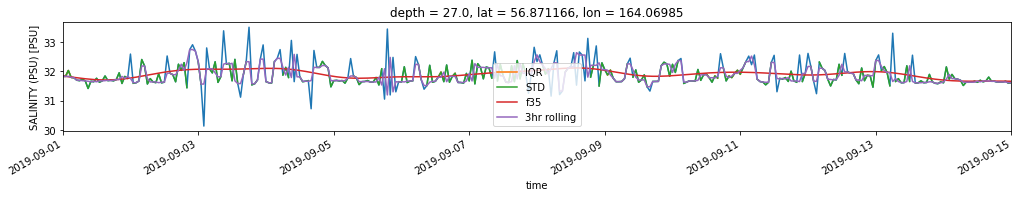

In [10]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)

ax.legend()
ax.set_xlim([datetime.date(2019,9,1),datetime.date(2019,9,15)])

*Finally* try to refill as many points back to the start and finish of the 

In [11]:
N = 3
clean = cleaning.rolling_outlier_std(xdf,var_choice,timebase=N*2+1,stddev=5,interp_fill_timebase='1H')
clean['S_41'][:N+1] = xdf['S_41'][:N+1]
clean['S_41'][-N-1:] = xdf['S_41'][-N-1:]

(18140.0, 18154.0)

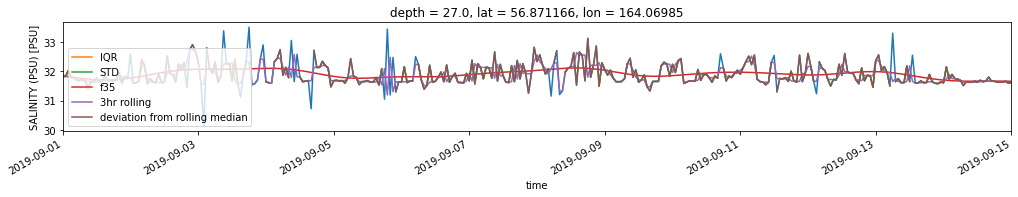

In [12]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)
clean[var_choice].plot(label='deviation from rolling median', ax=ax)

ax.legend()
ax.set_xlim([datetime.date(2019,9,1),datetime.date(2019,9,15)])

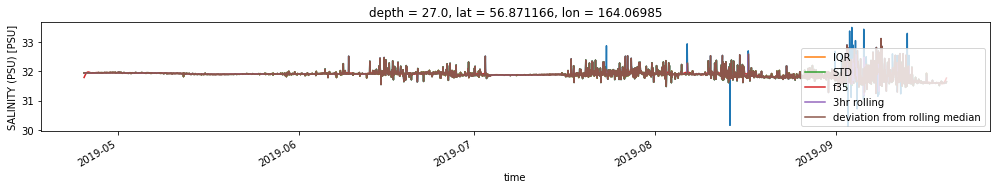

In [15]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)
clean[var_choice].plot(label='deviation from rolling median', ax=ax)

ax.legend()